In [ ]:
# df.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,week_num,year
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,3,2011
1,1097,2011-01-17,9672,223153,192.3750,236.5500,1,1,109,3,2011
2,1096,2011-01-17,9672,223245,207.3375,207.3375,0,0,61,3,2011
3,1095,2011-01-17,9672,222765,241.5375,241.5375,0,0,49,3,2011
4,1094,2011-01-17,9672,222087,181.6875,207.3375,1,0,129,3,2011


In [14]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# File paths for Kaggle
TRAIN_FILE = 'dataset_devcamp.csv'
TEST_FILE = 'test_final.csv'
SUBMISSION_FILE = 'Submission.csv'

# Load datasets
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)

# Target and ID columns
target_column = "units_sold"
id_column = "record_ID"

# Drop unused columns (like 'week')
columns_to_drop = [target_column, id_column, 'week']
X = train_df.drop(columns=columns_to_drop)
y = train_df[target_column]

# Prepare test data
test_ids = test_df[id_column]
X_test = test_df.drop(columns=[id_column, 'week'])

# Combine train + test for consistent preprocessing
full_data = pd.concat([X, X_test], axis=0)

# Imputation and Scaling
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

full_data_imputed = imputer.fit_transform(full_data)
full_data_scaled = scaler.fit_transform(full_data_imputed)

# Split back
X_processed = full_data_scaled[:len(X)]
X_test_processed = full_data_scaled[len(X):]

# Model with tuned hyperparameters
model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.017161193655178805,
    max_depth=7,
    min_child_weight=8,
    subsample=0.9371329463047965,
    colsample_bytree=0.7020260759420183,
    gamma=0.11565669827630881,
    reg_alpha=0.11274999271489358,
    reg_lambda=0.8760609600713415,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Cross-validation
cv_scores = cross_val_score(model, X_processed, y, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validation RMSE scores:", -cv_scores)
print("Average RMSE:", -cv_scores.mean())

# Train on full dataset
model.fit(X_processed, y)

# Predict on test
predictions = model.predict(X_test_processed)

# Create submission file
submission = pd.DataFrame({
    id_column: test_ids,
    target_column: predictions
})

submission.to_csv(SUBMISSION_FILE, index=False)
print("✅ Submission saved to:", SUBMISSION_FILE)


# print(f"\n🎯 Final Test RMSE: {rmse_test:.2f}")
# print(f"🎯 Final Test R² Score: {r2_test:.2f}")

Cross-validation RMSE scores: [44.14745671 29.61831418 34.73984714 27.45382617 32.6259928 ]
Average RMSE: 33.717087399683166
✅ Submission saved to: Submission.csv


✅ Cross-Validated RMSE (5-fold):
  - Mean: 30.49
  - Std Dev: 1.52

🎯 Final Test RMSE: 31.54
🎯 Final Test R² Score: 0.75


In [5]:
# from tqdm import tqdm

# from sklearn.model_selection import GridSearchCV
# # Split dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define model
# rf = RandomForestRegressor(random_state=42)

# # 🔧 Define parameter grid
# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# # ⚙️ GridSearchCV with 5-fold CV
# print("🔍 Running GridSearchCV...")
# grid_search = GridSearchCV(estimator=rf,
#                            param_grid=param_grid,
#                            cv=5,
#                            scoring='neg_root_mean_squared_error',
#                            verbose=1,
#                            n_jobs=-1)

# grid_search.fit(X_train, y_train)

# # ✅ Best parameters and model
# best_model = grid_search.best_estimator_
# print(f"\n🏆 Best Parameters: {grid_search.best_params_}")

# # 📈 Evaluate on test set
# y_pred = best_model.predict(X_test)
# rmse_test = mean_squared_error(y_test, y_pred, squared=False)
# r2_test = r2_score(y_test, y_pred)

In [8]:

# import optuna
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
# from sklearn.metrics import mean_squared_error, r2_score
# import xgboost as xgb
# import lightgbm as lgb
# import numpy as np
# from tqdm import tqdm
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define Optuna objective
# def objective(trial):
#     model_name = trial.suggest_categorical("model", ["RandomForest", "GradientBoosting", "XGBoost", "LightGBM", "ExtraTrees"])

#     if model_name == "RandomForest":
#         model = RandomForestRegressor(
#             n_estimators=trial.suggest_int("n_estimators", 100, 300),
#             max_depth=trial.suggest_int("max_depth", 5, 30),
#             min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
#             min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
#             random_state=42
#         )

#     elif model_name == "GradientBoosting":
#         model = GradientBoostingRegressor(
#             n_estimators=trial.suggest_int("n_estimators", 100, 300),
#             learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
#             max_depth=trial.suggest_int("max_depth", 3, 20),
#             subsample=trial.suggest_float("subsample", 0.6, 1.0),
#             random_state=42
#         )

#     elif model_name == "XGBoost":
#         model = xgb.XGBRegressor(
#             n_estimators=trial.suggest_int("n_estimators", 100, 300),
#             max_depth=trial.suggest_int("max_depth", 3, 20),
#             learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
#             subsample=trial.suggest_float("subsample", 0.6, 1.0),
#             colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
#             random_state=42,
#             n_jobs=-1
#         )

#     elif model_name == "LightGBM":
#         model = lgb.LGBMRegressor(
#             n_estimators=trial.suggest_int("n_estimators", 100, 300),
#             max_depth=trial.suggest_int("max_depth", 3, 20),
#             learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
#             subsample=trial.suggest_float("subsample", 0.6, 1.0),
#             colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
#             random_state=42,
#             n_jobs=-1
#         )

#     elif model_name == "ExtraTrees":
#         model = ExtraTreesRegressor(
#             n_estimators=trial.suggest_int("n_estimators", 100, 300),
#             max_depth=trial.suggest_int("max_depth", 5, 30),
#             min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
#             min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
#             random_state=42
#         )

#     # Cross-validation
#     score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
#     return -1 * score.mean()

# # Run Optuna study
# print("🚀 Running Optuna optimization...")
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=30)

# # Get best model and test score
# print(f"\n🏆 Best Trial: {study.best_trial.value:.2f}")
# print(f"⚙️ Best Parameters: {study.best_trial.params}")
!pip install pandas numpy scikit-learn optuna xgboost lightgbm tqdm

  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.2.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached optuna-4.3.0-py3-none-any.whl.metadata (17 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)
Using cached numpy-2.2.4-cp312-cp312-win_amd64.whl (12.6 MB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\PC\OneDrive\Bureau\Dev-Camp 3.0\env\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\PC\OneDrive\Bureau\Dev-Camp 3.0\env\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC\OneDrive\Bureau\Dev-Camp 3.0\env\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC\OneDrive\Bureau\Dev-Camp 3.0\env\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC\miniconda3\Lib\

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- 1. Load Data ---
# Replace 'your_sales_data.csv' with the actual path to your data file
try:
    # Assuming the image data is saved in a CSV file like this:
    # index,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,week_num,year
    # 0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,3,2011
    # 1,1097,2011-01-17,9672,223153,192.375,236.55,1,1,109,3,2011
    # ... etc.
    df = pd.read_csv('dataset_devcamp.csv', index_col=0) # Use index_col=0 if the first column is the unnamed index
    print("Data loaded successfully.")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData Info:")
    df.info()
except FileNotFoundError:
    print("Error: 'your_sales_data.csv' not found.")
    print("Please make sure the CSV file is in the correct directory or provide the full path.")
    exit() # Exit if the file isn't found
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    exit()

# --- 2. Basic Preprocessing ---
print("\n--- Preprocessing ---")
# Convert 'week' column to datetime objects
df['week'] = pd.to_datetime(df['week'])

# Sort data chronologically - ESSENTIAL for time series
df.sort_values(by=['store_id', 'sku_id', 'week'], inplace=True)
print("Converted 'week' to datetime and sorted data.")



Data loaded successfully.
Dataset shape: (133980, 8)

First 5 rows:
                 week  store_id  sku_id  total_price  base_price  \
record_ID                                                          
1          2011-01-17      8091  216418      99.0375    111.8625   
1097       2011-01-17      9672  223153     192.3750    236.5500   
1096       2011-01-17      9672  223245     207.3375    207.3375   
1095       2011-01-17      9672  222765     241.5375    241.5375   
1094       2011-01-17      9672  222087     181.6875    207.3375   

           is_featured_sku  is_display_sku  units_sold  
record_ID                                               
1                        0               0          20  
1097                     1               1         109  
1096                     0               0          61  
1095                     0               0          49  
1094                     1               0         129  

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index:

In [2]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())
# Simple imputation (example: fill with 0 or median/mean if appropriate)
# df.fillna(0, inplace=True) # Be cautious with this, understand why data is missing

# --- 3. Feature Engineering ---
print("\n--- Feature Engineering ---")

# Time-based features
df['year'] = df['week'].dt.year
df['month'] = df['week'].dt.month
df['weekofyear'] = df['week'].dt.isocalendar().week.astype(int) # Use ISO week number
df['dayofweek'] = df['week'].dt.dayofweek # Monday=0, Sunday=6




Missing values per column:
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

--- Feature Engineering ---


In [3]:
# Lag features (sales in previous weeks for the same store-sku)
# Important: Group by store and sku to avoid data leakage across items
print("Creating lag features...")
lags = [1, 2, 4] # Sales from 1, 2, and 4 weeks ago
for lag in lags:
    df[f'lag_{lag}_sales'] = df.groupby(['store_id', 'sku_id'])['units_sold'].shift(lag)

# Rolling window features (e.g., average sales over the last N weeks)
print("Creating rolling window features...")
window_size = 4
# Calculate rolling mean on lagged data to prevent leakage from current week's target
df[f'rolling_{window_size}_mean_sales'] = df.groupby(['store_id', 'sku_id'])['units_sold'].shift(1).rolling(window=window_size, min_periods=1).mean()
# Calculate rolling std dev
df[f'rolling_{window_size}_std_sales'] = df.groupby(['store_id', 'sku_id'])['units_sold'].shift(1).rolling(window=window_size, min_periods=1).std()



Creating lag features...
Creating rolling window features...


In [4]:

# Price features
df['price_diff'] = df['base_price'] - df['total_price']
df['discount_perc'] = (df['price_diff'] / df['base_price']).fillna(0) * 100 # Handle base_price=0
df['discount_perc'] = df['discount_perc'].replace([np.inf, -np.inf], 0) # Handle potential division by zero

# Drop rows with NaNs created by lag/rolling features (start of each time series)
initial_rows = df.shape[0]
df.dropna(inplace=True)
print(f"Dropped {initial_rows - df.shape[0]} rows with NaN values created by lag/rolling features.")

print("\nFeature engineering complete. Example features:")
print(df[['week', 'store_id', 'sku_id', 'units_sold', 'lag_1_sales', f'rolling_{window_size}_mean_sales', 'price_diff']].head())

# --- 4. Data Splitting (Time-Based) ---
print("\n--- Splitting Data (Time-Based) ---")



Dropped 4620 rows with NaN values created by lag/rolling features.

Feature engineering complete. Example features:


                week  store_id  sku_id  units_sold  lag_1_sales  \
record_ID                                                         
6651      2011-02-14      8023  216233          93        115.0   
8289      2011-02-21      8023  216233         150         93.0   
9923      2011-02-28      8023  216233         134        150.0   
11537     2011-03-07      8023  216233         130        134.0   
13151     2011-03-14      8023  216233         167        130.0   

           rolling_4_mean_sales  price_diff  
record_ID                                    
6651                     112.75      0.0000  
8289                     107.50     17.8125  
9923                     123.25     17.8125  
11537                    123.00     15.6750  
13151                    126.75     17.1000  

--- Splitting Data (Time-Based) ---


Training data shape: X=(115500, 17), y=(115500,)
Test data shape: X=(13860, 17), y=(13860,)
Test period starts from: 2013-01-15 00:00:00

--- Training RandomForestRegressor Model ---
Model training complete.

--- Making Predictions and Evaluating ---
Evaluation Metrics on Test Set:
  Mean Absolute Error (MAE): 17.7620
  Root Mean Squared Error (RMSE): 30.9344
  R-squared (R²): 0.6114

--- Feature Importance ---
                 feature  importance
12           lag_1_sales    0.325123
15  rolling_4_mean_sales    0.174230
11         discount_perc    0.128308
4        is_featured_sku    0.113499
2            total_price    0.056861
16   rolling_4_std_sales    0.035312
14           lag_4_sales    0.029232
1                 sku_id    0.027173
13           lag_2_sales    0.024126
8             weekofyear    0.023682
3             base_price    0.013952
0               store_id    0.013151
5         is_display_sku    0.012790
10            price_diff    0.011877
7                  month    0.

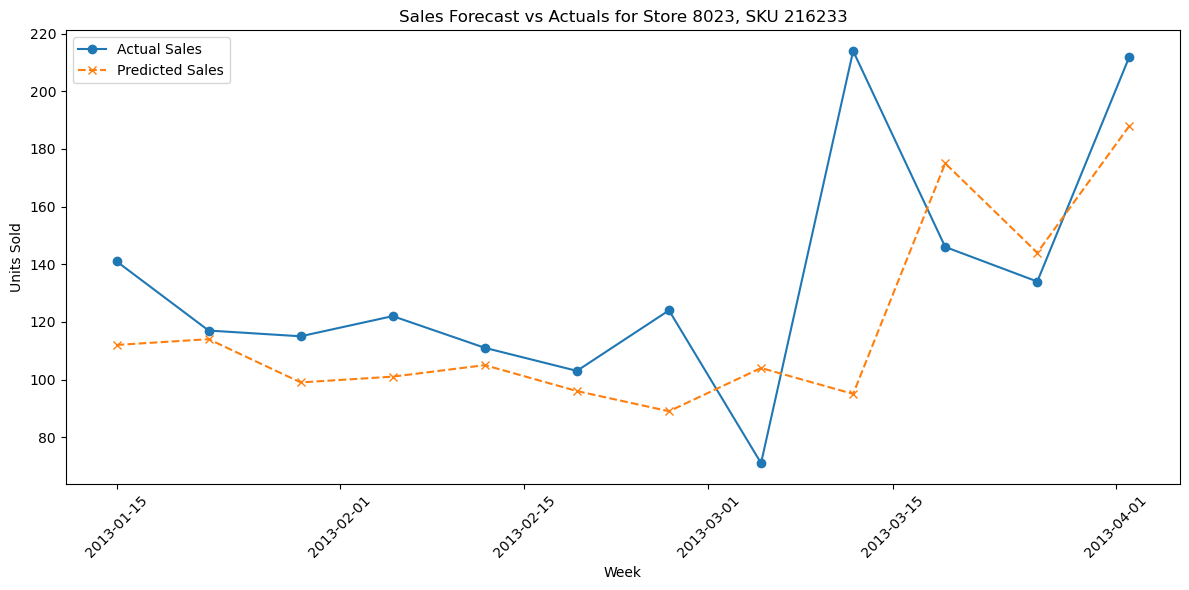

In [5]:
# Define features (X) and target (y)
# Note: 'record_ID' is usually not a feature. 'week' is used for splitting but often time components (year, month etc) are the features.
features = [
    'store_id', 'sku_id', 'total_price', 'base_price',
    'is_featured_sku', 'is_display_sku',
    'year', 'month', 'weekofyear', 'dayofweek', # Time features
    'price_diff', 'discount_perc',             # Price features
    'lag_1_sales', 'lag_2_sales', 'lag_4_sales', # Lag features
    f'rolling_{window_size}_mean_sales', f'rolling_{window_size}_std_sales' # Rolling window features
]
target = 'units_sold'

# Determine split point (e.g., use last 12 weeks for testing)
unique_weeks = df['week'].unique()

split_date = unique_weeks[-12] # Example: use last 12 unique weeks for test

train_df = df[df['week'] < split_date]
test_df = df[df['week'] >= split_date]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")
print(f"Test period starts from: {test_df['week'].min()}")

# --- 5. Model Training ---
print("\n--- Training RandomForestRegressor Model ---")

# Initialize the model - parameters can be tuned
rf_model = RandomForestRegressor(
    n_estimators=100,    # Number of trees
    random_state=42,     # For reproducibility
    n_jobs=-1,           # Use all available CPU cores
    max_depth=15,        # Limit tree depth to prevent overfitting (tune this)
    min_samples_split=10, # Min samples required to split a node (tune this)
    min_samples_leaf=5   # Min samples required at a leaf node (tune this)
)

# Train the model
rf_model.fit(X_train, y_train)
print("Model training complete.")

# --- 6. Prediction & Evaluation ---
print("\n--- Making Predictions and Evaluating ---")

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Ensure predictions are non-negative integers (as units sold cannot be fractional or negative)
predictions = np.maximum(0, predictions).round().astype(int)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"Evaluation Metrics on Test Set:")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"  R-squared (R²): {r2:.4f}")

# --- Optional: Feature Importance ---
print("\n--- Feature Importance ---")
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

# --- Optional: Visualize Predictions vs Actuals (Sample) ---
print("\n--- Visualizing Sample Predictions ---")
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions, 'Week': test_df['week']})
# Plot a sample for a specific store/sku if desired
sample_store = test_df['store_id'].iloc[0]
sample_sku = test_df['sku_id'].iloc[0]
sample_results = results_df[(test_df['store_id'] == sample_store) & (test_df['sku_id'] == sample_sku)].sort_values('Week')

if not sample_results.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(sample_results['Week'], sample_results['Actual'], label='Actual Sales', marker='o')
    plt.plot(sample_results['Week'], sample_results['Predicted'], label='Predicted Sales', marker='x', linestyle='--')
    plt.title(f'Sales Forecast vs Actuals for Store {sample_store}, SKU {sample_sku}')
    plt.xlabel('Week')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(f"No data found for sample store {sample_store} and SKU {sample_sku} in the test set to plot.")


# print("\n--- Script Finished ---")

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import optuna


# --- Set random seed for reproducibility ---
SEED = 42
np.random.seed(SEED)

# --- Custom scorer for RMSE (since GridSearchCV maximizes, we use neg_root_mean_squared_error) ---
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Use make_scorer if you want to use RMSE directly with Optuna (minimization)
# For GridSearchCV, sklearn provides 'neg_root_mean_squared_error' which works well.

# --- 1. Load Data (Same as before) ---
try:
    df = pd.read_csv('dataset_devcamp.csv', index_col=0)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'your_sales_data.csv' not found.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    exit()


Data loaded successfully.


In [23]:
df.head()

,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,year,month,weekofyear,dayofweek,lag_1_sales,lag_2_sales,lag_4_sales,rolling_4_mean_sales,rolling_4_std_sales,price_diff,discount_perc
record_ID,,,,,,,,,,,,,,,,,,,
6651,2011-02-14,8023,216233,133.2375,133.2375,0,0,93,2011,2,7,0,115.0,135.0,114.0,112.75,19.704060,0.0000,0.000000
8289,2011-02-21,8023,216233,115.4250,133.2375,0,0,150,2011,2,8,0,93.0,115.0,87.0,107.50,21.931712,17.8125,13.368984
9923,2011-02-28,8023,216233,115.4250,133.2375,0,0,134,2011,2,9,0,150.0,93.0,135.0,123.25,24.743686,17.8125,13.368984
11537,2011-03-07,8023,216233,117.5625,133.2375,0,0,130,2011,3,10,0,134.0,150.0,115.0,123.00,24.589971,15.6750,11.764706
13151,2011-03-14,8023,216233,116.1375,133.2375,0,0,167,2011,3,11,0,130.0,134.0,93.0,126.75,24.102213,17.1000,12.834225


Enter feature values one by one:


ValueError: Feature shape mismatch, expected: 126, got 17

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

# File paths for Kaggle
TRAIN_FILE = 'dataset_devcamp.csv'
TEST_FILE = 'test_final.csv'
SUBMISSION_FILE = 'Submission.csv'

# Load datasets
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)

# Target and ID columns
target_column = "units_sold"
id_column = "record_ID"

# Feature Engineering
def add_features(df):
    # Create a copy to avoid warnings
    df = df.copy()
    
    # Extract date components
    df['week'] = pd.to_datetime(df['week'])
    df['month'] = df['week'].dt.month
    df['day_of_week'] = df['week'].dt.dayofweek
    df['quarter'] = df['week'].dt.quarter
    
    # Price features
    df['discount'] = df['base_price'] - df['total_price']
    df['discount_percentage'] = (df['discount'] / df['base_price']).fillna(0)
    df['is_discounted'] = (df['discount'] > 0).astype(int)
    
    # Promotional effects combined
    df['promo_display'] = df['is_featured_sku'] + df['is_display_sku']
    
    # Store-SKU interaction
    df['store_sku'] = df['store_id'].astype(str) + '_' + df['sku_id'].astype(str)
    
    # Drop original week column
    df = df.drop('week', axis=1)
    
    return df

# Apply feature engineering
train_df = add_features(train_df)
test_df = add_features(test_df)

#features
cat_features = ['store_id', 'sku_id', 'month', 'day_of_week', 'quarter', 'store_sku']
for col in cat_features:
    if col in train_df.columns:
        if col == 'store_sku':
            # For high cardinality features, use target encoding
            means = train_df.groupby(col)[target_column].mean()
            train_df[f'{col}_encoded'] = train_df[col].map(means)
            test_df[f'{col}_encoded'] = test_df[col].map(means)
            # Fill missing values with global mean
            global_mean = train_df[target_column].mean()
            test_df[f'{col}_encoded'] = test_df[f'{col}_encoded'].fillna(global_mean)
        else:
            # For other categorical features, use one-hot encoding
            dummies = pd.get_dummies(pd.concat([train_df[col], test_df[col]]), prefix=col, drop_first=True)
            train_df = pd.concat([train_df, dummies.iloc[:len(train_df)]], axis=1)
            test_df = pd.concat([test_df, dummies.iloc[len(train_df):].reset_index(drop=True)], axis=1)

# Drop original categorical columns and other columns we don't need for modeling
cols_to_drop = cat_features + [target_column, id_column]
X = train_df.drop(columns=[col for col in cols_to_drop if col in train_df.columns])
y = train_df[target_column]

# Prepare test data
test_ids = test_df[id_column]
X_test = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns])

# Make sure X and X_test have the same columns
common_columns = set(X.columns).intersection(set(X_test.columns))
X = X[list(common_columns)]
X_test = X_test[list(common_columns)]

# Handle missing values and scaling
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Process the data
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

X_processed = scaler.fit_transform(X_imputed)
X_test_processed = scaler.transform(X_test_imputed)

# Setup KFold cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Fine-tune hyperparameters with RandomizedSearchCV
params = {
    'n_estimators': randint(500, 1500),
    'learning_rate': uniform(0.01, 0.09),
    'max_depth': randint(4, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Base model
base_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # faster and typically performs well
    random_state=42,
    n_jobs=-1
)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=params,
    n_iter=25,  # try 25 parameter combinations
    scoring='neg_root_mean_squared_error',
    cv=kf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit randomized search
random_search.fit(X_processed, y)

# Get best parameters
best_params = random_search.best_params_
print("Best parameters:", best_params)
print("Best RMSE:", -random_search.best_score_)

# Train final model with best parameters
final_model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

# Cross-validation with best model
cv_scores = cross_val_score(final_model, X_processed, y, cv=kf, scoring='neg_root_mean_squared_error')
print("Cross-validation RMSE scores:", -cv_scores)
print("Average RMSE:", -cv_scores.mean())

# Train on full dataset
final_model.fit(X_processed, y)

# Feature importance
feature_importance = final_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
print("Top 10 important features:")
for i in sorted_idx[:10]:
    if i < len(X.columns):
        print(f"{X.columns[i]}: {feature_importance[i]}")

# Predict on test
predictions = final_model.predict(X_test_processed)

# Create submission file
submission = pd.DataFrame({
    id_column: test_ids,
    target_column: predictions.clip(0)  # ensure no negative predictions
})
submission.to_csv(SUBMISSION_FILE, index=False)
print("✅ Submission saved to:", SUBMISSION_FILE)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'colsample_bytree': 0.9016406642217635, 'gamma': 0.3808098076643588, 'learning_rate': 0.03138737895931597, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 1336, 'reg_alpha': 0.6323058305935795, 'reg_lambda': 0.6335297107608947, 'subsample': 0.8607324052224274}
Best RMSE: 22.863289701021063
Cross-validation RMSE scores: [22.95562221 21.3439253  23.94484197 24.03049166 22.04156736]
Average RMSE: 22.863289701021063
Top 10 important features:
is_featured_sku: 0.1724996268749237
promo_display: 0.06965570151805878
store_sku_encoded: 0.06470037996768951
sku_id_219009: 0.0596914105117321
store_id_9845: 0.036928996443748474
discount_percentage: 0.03034246526658535
month_2: 0.020555058494210243
sku_id_547934: 0.019958708435297012
sku_id_223245: 0.01816149801015854
store_id_9273: 0.016345182433724403
✅ Submission saved to: Submission.csv


In [21]:
final_model.save_model('xgb_model_forecast.json')
final_model.load_model('xgb_model_forecast.json')

In [48]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

# File paths for Kaggle
TRAIN_FILE = 'dataset_devcamp.csv'
TEST_FILE = 'test_final.csv'
SUBMISSION_FILE = 'Submission.csv'

# Load datasets
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)

# Target and ID columns
target_column = "units_sold"
id_column = "record_ID"

# Feature Engineering
def add_features(df):
    # Create a copy to avoid warnings
    df = df.copy()
    
    # Extract date components
    df['week'] = pd.to_datetime(df['week'])
    df['month'] = df['week'].dt.month
    df['day_of_week'] = df['week'].dt.dayofweek
    df['quarter'] = df['week'].dt.quarter
    
    # Price features
    df['discount'] = df['base_price'] - df['total_price']
    df['discount_percentage'] = (df['discount'] / df['base_price']).fillna(0)
    df['is_discounted'] = (df['discount'] > 0).astype(int)
    
    # Promotional effects combined
    df['promo_display'] = df['is_featured_sku'] + df['is_display_sku']
    
    # Store-SKU interaction
    df['store_sku'] = df['store_id'].astype(str) + '_' + df['sku_id'].astype(str)
    
    # Drop original week column
    df = df.drop('week', axis=1)
    
    return df

# Apply feature engineering
train_df = add_features(train_df)
test_df = add_features(test_df)

#features
cat_features = ['store_id', 'sku_id', 'month', 'day_of_week', 'quarter', 'store_sku']
for col in cat_features:
    if col in train_df.columns:
        if col == 'store_sku':
            # For high cardinality features, use target encoding
            means = train_df.groupby(col)[target_column].mean()
            train_df[f'{col}_encoded'] = train_df[col].map(means)
            test_df[f'{col}_encoded'] = test_df[col].map(means)
            # Fill missing values with global mean
            global_mean = train_df[target_column].mean()
            test_df[f'{col}_encoded'] = test_df[f'{col}_encoded'].fillna(global_mean)
        else:
            # For other categorical features, use one-hot encoding
            dummies = pd.get_dummies(pd.concat([train_df[col], test_df[col]]), prefix=col, drop_first=True)
            train_df = pd.concat([train_df, dummies.iloc[:len(train_df)]], axis=1)
            test_df = pd.concat([test_df, dummies.iloc[len(train_df):].reset_index(drop=True)], axis=1)

# Drop original categorical columns and other columns we don't need for modeling
cols_to_drop = cat_features + [target_column, id_column]
X = train_df.drop(columns=[col for col in cols_to_drop if col in train_df.columns])
y = train_df[target_column]

# Prepare test data
test_ids = test_df[id_column]
X_test = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns])

# Make sure X and X_test have the same columns
common_columns = set(X.columns).intersection(set(X_test.columns))
X = X[list(common_columns)]
X_test = X_test[list(common_columns)]

# Handle missing values and scaling
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Process the data
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

X_processed = scaler.fit_transform(X_imputed)
X_test_processed = scaler.transform(X_test_imputed)

# Setup KFold cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [49]:
train_df.head(10)

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,month,day_of_week,...,month_8,month_9,month_10,month_11,month_12,day_of_week_1,quarter_2,quarter_3,quarter_4,store_sku_encoded
0,1,8091,216418,99.0375,111.8625,0,0,20,1,0,...,False,False,False,False,False,False,False,False,False,27.672414
1,1097,9672,223153,192.3750,236.5500,1,1,109,1,0,...,False,False,False,False,False,False,False,False,False,55.482759
2,1096,9672,223245,207.3375,207.3375,0,0,61,1,0,...,False,False,False,False,False,False,False,False,False,72.991379
3,1095,9672,222765,241.5375,241.5375,0,0,49,1,0,...,False,False,False,False,False,False,False,False,False,63.801724
4,1094,9672,222087,181.6875,207.3375,1,0,129,1,0,...,False,False,False,False,False,False,False,False,False,61.129310
5,1093,9672,219029,327.0375,327.0375,0,0,39,1,0,...,False,False,False,False,False,False,False,False,False,56.784483
6,1092,9672,219009,215.8875,215.8875,0,0,28,1,0,...,False,False,False,False,False,False,False,False,False,80.241379
7,1100,9672,245338,431.0625,448.1625,1,0,38,1,0,...,False,False,False,False,False,False,False,False,False,33.810345
8,1088,9672,217390,139.6500,139.6500,0,0,100,1,0,...,False,False,False,False,False,False,False,False,False,76.818966
9,1086,9672,216425,133.9500,133.9500,0,0,21,1,0,...,False,False,False,False,False,False,False,False,False,40.456897


In [ ]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import uniform, randint



# --- Encoding / dummies / target‐encode store_sku ---
# (same as before…)

# Drop unused columns
drop_cols = [target_column, id_column]
X = train_df.drop(columns=drop_cols)
y = train_df[target_column]
test_ids = test_df[id_column]
X_test = test_df.drop(columns=[*drop_cols, target_column], errors='ignore')

# Align train & test
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

# Preprocessing pipeline
preprocessor = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',  StandardScaler())
])

X_proc      = preprocessor.fit_transform(X)
X_test_proc = preprocessor.transform(X_test)

# CV splitter
kf = KFold(n_splits=5, shuffle=True, random_state=42)



def tune_model(estimator, param_dist, X, y, cv):
    rs = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=20,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )
    rs.fit(X, y)
    print(f">>> {estimator.__class__.__name__} best RMSE: {-rs.best_score_:.4f}")
    return rs.best_estimator_
#stack modeling
# XGBoost param dist
xgb_dist = {
    'n_estimators': randint(500,1500),
    'learning_rate': uniform(0.01,0.09),
    'max_depth': randint(4,10),
    'subsample': uniform(0.6,0.4),
    'colsample_bytree': uniform(0.6,0.4),
    'gamma': uniform(0,0.5),
    'reg_alpha': uniform(0,1),
    'reg_lambda': uniform(0,1)
}
best_xgb = tune_model(
    XGBRegressor(
        objective='reg:squarederror', 
        tree_method='hist',
        random_state=42, 
        n_jobs=-1
    ),
    xgb_dist, X_proc, y, kf
)


# LightGBM
lgbm_dist = {
    'n_estimators': randint(500,1500),
    'learning_rate': uniform(0.01,0.09),
    'num_leaves': randint(20,150),
    'subsample': uniform(0.6,0.4),
    'colsample_bytree': uniform(0.6,0.4),
    'reg_alpha': uniform(0,1),
    'reg_lambda': uniform(0,1)
}
best_lgbm = tune_model(
    LGBMRegressor(objective='regression', random_state=42, n_jobs=-1),
    lgbm_dist, X_proc, y, kf
)

# CatBoost
cat_dist = {
    'iterations': randint(500,1500),
    'learning_rate': uniform(0.01,0.09),
    'depth': randint(4,10),
    'l2_leaf_reg': uniform(0,5),
    'random_strength': uniform(0,5)
}
best_cat = tune_model(
    CatBoostRegressor(verbose=0, random_state=42),
    cat_dist, X_proc, y, kf
)

# --- 2) Build a Stacking Ensemble -----------------------------

estimators = [
    ('xgb',  best_xgb),
    ('lgbm', best_lgbm),
    ('cat',  best_cat)
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0, random_state=42),
    cv=kf,
    n_jobs=-1,
    passthrough=True
)

# CV performance of stack
stack_scores = -cross_val_score(stack, X_proc, y,
                                cv=kf,
                                scoring='neg_root_mean_squared_error',
                                n_jobs=-1)
print(f"\nStacking CV RMSE: {stack_scores.mean():.4f} ± {stack_scores.std():.4f}")

# Train stack on full data
stack.fit(X_proc, y)



preds = stack.predict(X_test_proc)
submission = pd.DataFrame({
    id_column: test_ids,
    target_column: np.clip(preds, 0, None)
})
submission.to_csv(SUBMISSION_FILE, index=False)
print(f"✅ Submission saved to {SUBMISSION_FILE}")


>>> XGBRegressor best RMSE: 23.0705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1984
[LightGBM] [Info] Number of data points in the train set: 133980, number of used features: 132
[LightGBM] [Info] Start training from score 51.770645
>>> LGBMRegressor best RMSE: 22.1731
>>> CatBoostRegressor best RMSE: 22.2040

Stacking CV RMSE: 21.9525 ± 0.9509
✅ Submission saved to Submission.csv


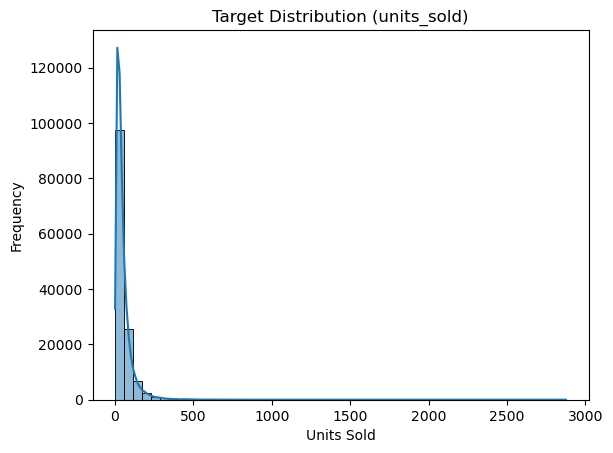

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train_df['units_sold'], kde=True, bins=50)
plt.title('Target Distribution (units_sold)')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()


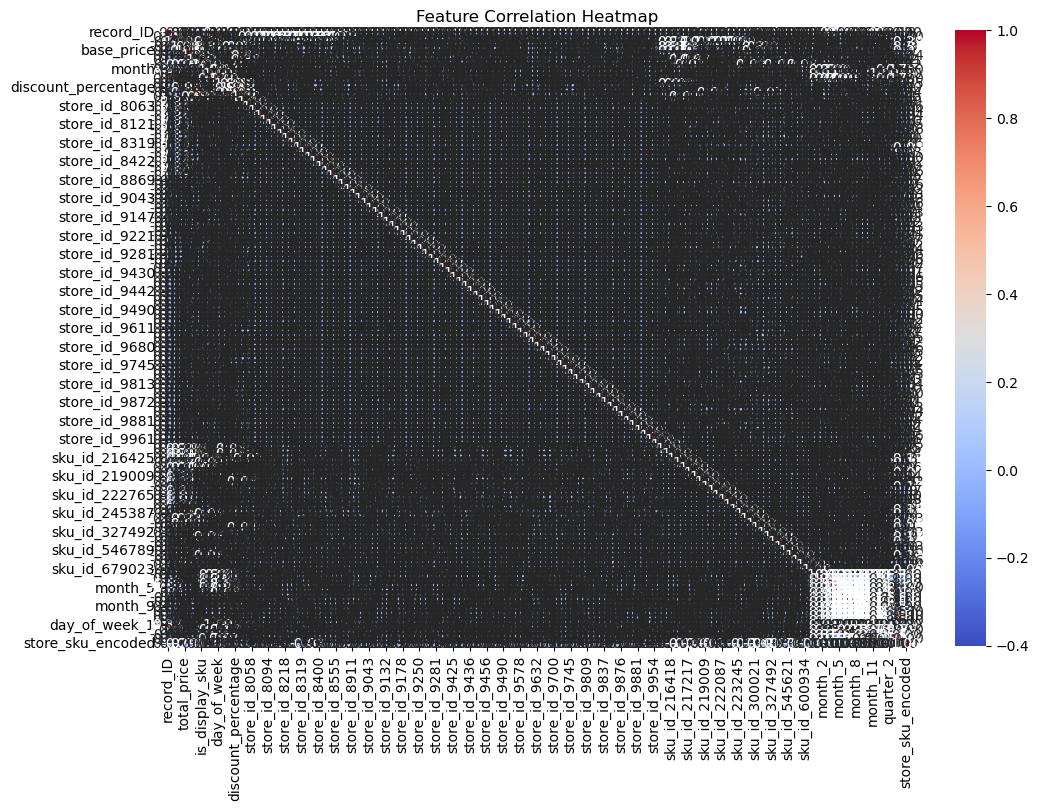

In [54]:
corr = train_df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Feature Correlation Heatmap')
plt.show()


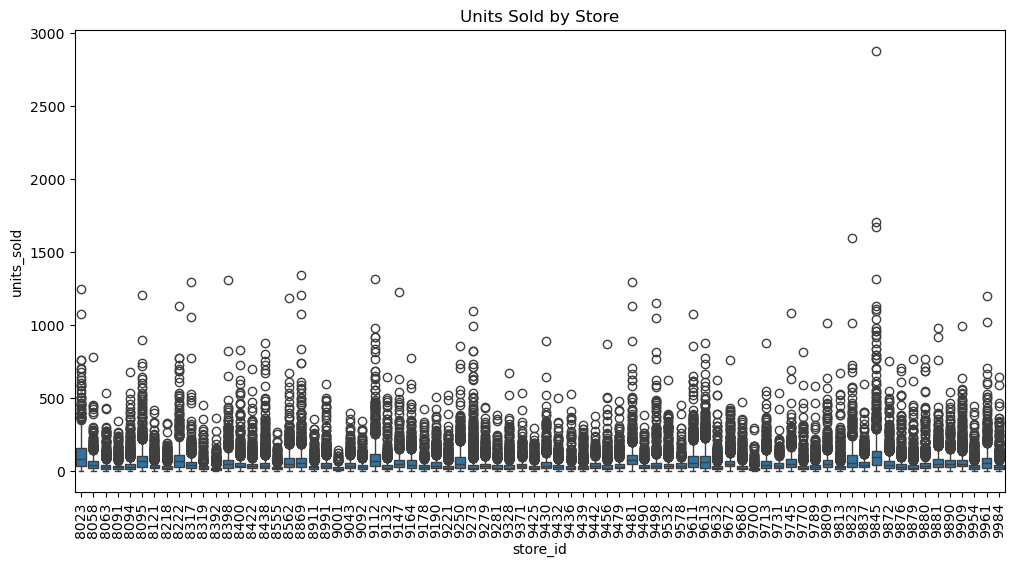

In [55]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='store_id', y='units_sold')
plt.xticks(rotation=90)
plt.title('Units Sold by Store')
plt.show()


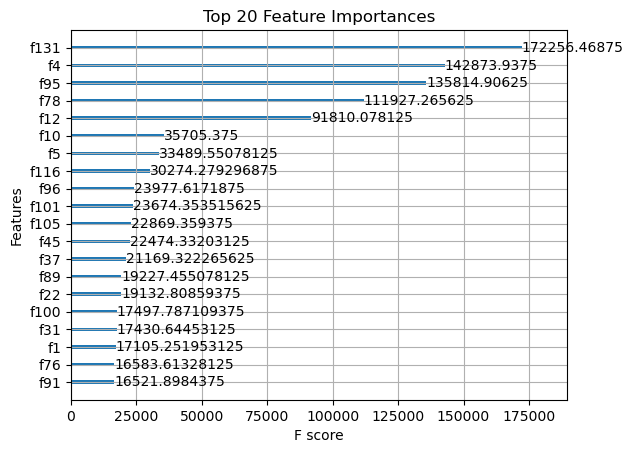

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Récupérer les scores d'importance par "gain"
feature_importances = best_xgb.get_booster().get_score(importance_type='gain')

# Convertir en DataFrame
importance_df = pd.DataFrame({
    'Feature': list(feature_importances.keys()),
    'Gain': list(feature_importances.values())
})

# Trier et afficher les 20 plus importantes
top_features = importance_df.sort_values(by='Gain', ascending=False).head(20)
print("Top 20 Feature Names by Gain:\n", top_features['Feature'].tolist())

# Affichage graphique
plot_importance(best_xgb, max_num_features=20, importance_type='gain')
plt.title('Top 20 Feature Importances by Gain')
plt.show()


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import StackingRegressor, VotingRegressor

import optuna
from optuna.integration import XGBoostPruningCallback

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# --- 1) Prepare data + features as before --------------------

# assume train_df, test_df, target_column, id_column have been defined
# plus your add_features() + encoding steps

X = train_df.drop(columns=[target_column, id_column])
y = train_df[target_column]
test_ids  = test_df[id_column]
X_test = test_df.drop(columns=[target_column, id_column], errors='ignore')

# align columns
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

# a small hold‑out for final early stopping (optional)
X_tr_full, X_hold, y_tr_full, y_hold = train_test_split(
    X, y, test_size=0.1, random_state=42)

# common 5‑fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- 2) Preprocessing pipeline -------------------------------

preprocessor = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',  StandardScaler()),
    ('poly',   PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('select', SelectFromModel(
        estimator=XGBRegressor(
            n_estimators=100, max_depth=3, 
            objective='reg:squarederror', 
            tree_method='hist', random_state=42),
        threshold='median'))
])

X_proc      = preprocessor.fit_transform(X_tr_full, y_tr_full)
X_hold_proc = preprocessor.transform(X_hold)
X_test_proc = preprocessor.transform(X_test)

# helper to run Optuna on a regressor
def tune_with_optuna(regressor_cls, param_space, X, y, cv, n_trials=30):
    def objective(trial):
        params = param_space(trial)
        # add pruning for XGB
        if regressor_cls is XGBRegressor:
            params['eval_metric'] = 'rmse'
            params['early_stopping_rounds'] = 50
        model = regressor_cls(**params)
        # for XGB / CatBoost, need an eval_set
        if hasattr(model, 'fit') and 'early_stopping_rounds' in params:
            # use holdout
            model.fit(X, y, eval_set=[(X_hold_proc, y_hold)], verbose=False)
            preds = model.predict(X_hold_proc)
            rmse = np.sqrt(((np.expm1(preds) - np.expm1(y_hold))**2).mean())
        else:
            scores = cross_val_score(
                model, X, y, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
            rmse = -scores.mean()
        trial.report(rmse, 0)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        return rmse

    study = optuna.create_study(direction='minimize', 
                                pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=n_trials)
    print(f"{regressor_cls.__name__} best RMSE: {study.best_value:.4f}")
    return regressor_cls(**study.best_params)

# XGBoost search space
def xgb_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 500,1500),
        'max_depth': trial.suggest_int('max_depth', 4,12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6,1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6,1.0),
        'gamma': trial.suggest_float('gamma', 0.0,0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0,1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0,1.0),
        'tree_method': 'hist',
        'random_state': 42
    }

# LightGBM space
def lgb_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 500,1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20,150),
        'subsample': trial.suggest_float('subsample', 0.6,1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6,1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0,1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0,1.0),
        'random_state': 42
    }

# CatBoost space
def cat_space(trial):
    return {
        'iterations': trial.suggest_int('iterations', 500,1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1, log=True),
        'depth': trial.suggest_int('depth', 4,12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0,10.0),
        'random_strength': trial.suggest_float('random_strength', 0.0,10.0),
        'verbose': False,
        'random_state': 42
    }

# Tune each base model
best_xgb  = tune_with_optuna(XGBRegressor, xgb_space,  X_proc, y_tr_full, kf)
best_lgbm = tune_with_optuna(LGBMRegressor, lgb_space, X_proc, y_tr_full, kf)
best_cat  = tune_with_optuna(CatBoostRegressor, cat_space, X_proc, y_tr_full, kf)

# --- 3) Build final ensembles -------------------------------

# 3a) Stacking with ElasticNetCV meta‐learner
stack = StackingRegressor(
    estimators=[
        ('xgb',  best_xgb),
        ('lgbm', best_lgbm),
        ('cat',  best_cat)
    ],
    final_estimator=ElasticNetCV(
        l1_ratio=[0.1,0.5,0.9],
        alphas=np.logspace(-3,1,10),
        cv=kf,
        n_jobs=-1
    ),
    cv=kf,
    n_jobs=-1,
    passthrough=True
)

stack_score = -cross_val_score(
    stack, X_proc, y_tr_full,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
).mean()
print(f"Stacking CV RMSE: {stack_score:.4f}")

stack.fit(X_proc, y_tr_full)

# 3b) Voting ensemble (adds robustness)
voting = VotingRegressor([
    ('xgb',  best_xgb),
    ('lgbm', best_lgbm),
    ('cat',  best_cat)
], weights=[.4, .3, .3])

voting_score = -cross_val_score(
    voting, X_proc, y_tr_full,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
).mean()
print(f"Voting CV RMSE: {voting_score:.4f}")

voting.fit(X_proc, y_tr_full)

# --- 4) Final predictions & blend ---------------------------

pred_stack  = stack.predict(X_test_proc)
pred_vote   = voting.predict(X_test_proc)

# simple blend
final_pred = 0.6*pred_stack + 0.4*pred_vote
final_pred = np.clip(final_pred, 0, None)

submission = pd.DataFrame({
    id_column: test_ids,
    target_column: final_pred
})
submission.to_csv('Optimized_Ensemble_Submission.csv', index=False)
print("✅ Saved to Optimized_Ensemble_Submission.csv")


[I 2025-04-19 08:21:38,456] A new study created in memory with name: no-name-bf756624-72b3-4e41-bfca-ac20a30a05ab
[I 2025-04-19 09:00:30,499] Trial 0 finished with value: inf and parameters: {'n_estimators': 750, 'max_depth': 11, 'learning_rate': 0.014926454008314802, 'subsample': 0.948594987624511, 'colsample_bytree': 0.779718701848235, 'gamma': 0.43178417582457806, 'reg_alpha': 0.6955689374112125, 'reg_lambda': 0.3615190773714547}. Best is trial 0 with value: inf.
[I 2025-04-19 09:33:28,221] Trial 1 finished with value: inf and parameters: {'n_estimators': 951, 'max_depth': 8, 'learning_rate': 0.024773438804143337, 'subsample': 0.9879531246465697, 'colsample_bytree': 0.8477166474498141, 'gamma': 0.3962570117364886, 'reg_alpha': 0.9836469228339167, 'reg_lambda': 0.5971594354241597}. Best is trial 0 with value: inf.
[I 2025-04-19 09:50:08,806] Trial 2 finished with value: inf and parameters: {'n_estimators': 604, 'max_depth': 11, 'learning_rate': 0.03934837443860241, 'subsample': 0.761

In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pickle
import os

# File paths
TRAIN_FILE = 'dataset_devcamp.csv'
MODEL_FILE = 'xgb_model.pkl'  # Your existing trained model

print("Starting PKL file creation process...")

# First, check if the model file exists
if not os.path.exists(MODEL_FILE):
    print(f"Error: {MODEL_FILE} not found. Please make sure your trained model exists.")
    exit(1)

# Load the trained model
print(f"Loading model from {MODEL_FILE}...")
with open(MODEL_FILE, 'rb') as f:
    model = pickle.load(f)
print("Model loaded successfully!")

# Load and preprocess the training data
print(f"Loading training data from {TRAIN_FILE}...")
try:
    train_df = pd.read_csv(TRAIN_FILE)
    print("Training data loaded successfully!")
except Exception as e:
    print(f"Error loading training data: {e}")
    exit(1)

# Target and ID columns
target_column = "units_sold"
id_column = "record_ID"

# Feature Engineering function
def add_features(df):
    # Create a copy to avoid warnings
    df = df.copy()
    
    # Extract date components
    df['week'] = pd.to_datetime(df['week'])
    df['month'] = df['week'].dt.month
    df['day_of_week'] = df['week'].dt.dayofweek
    df['quarter'] = df['week'].dt.quarter
    
    # Price features
    df['discount'] = df['base_price'] - df['total_price']
    df['discount_percentage'] = (df['discount'] / df['base_price']).fillna(0)
    df['is_discounted'] = (df['discount'] > 0).astype(int)
    
    # Promotional effects combined
    df['promo_display'] = df['is_featured_sku'] + df['is_display_sku']
    
    # Store-SKU interaction
    df['store_sku'] = df['store_id'].astype(str) + '_' + df['sku_id'].astype(str)
    
    # Drop original week column
    df = df.drop('week', axis=1)
    
    return df

# Apply feature engineering
print("Applying feature engineering...")
train_df = add_features(train_df)

# Save the store_sku mapping for target encoding
print("Creating encoding mappings...")
store_sku_means = train_df.groupby('store_sku')[target_column].mean().to_dict()
with open('store_sku_means.pkl', 'wb') as f:
    pickle.dump(store_sku_means, f)
print("Saved store_sku_means.pkl")

# features
cat_features = ['store_id', 'sku_id', 'month', 'day_of_week', 'quarter', 'store_sku']
cat_encoding_maps = {}  # Store encoding maps for categorical features

for col in cat_features:
    if col in train_df.columns:
        if col == 'store_sku':
            # For high cardinality features, use target encoding
            means = train_df.groupby(col)[target_column].mean()
            train_df[f'{col}_encoded'] = train_df[col].map(means)
            
            # Save the encoding mapping and global mean
            global_mean = train_df[target_column].mean()
            cat_encoding_maps[col] = {'mapping': means.to_dict(), 'global_mean': global_mean}
        else:
            # For other categorical features, use one-hot encoding
            dummies = pd.get_dummies(train_df[col], prefix=col, drop_first=True)
            train_df = pd.concat([train_df, dummies], axis=1)
            
            # Save dummy column names
            cat_encoding_maps[col] = {'dummy_columns': [c for c in dummies.columns]}

# Save categorical encoding information
with open('cat_encoding_maps.pkl', 'wb') as f:
    pickle.dump(cat_encoding_maps, f)
print("Saved cat_encoding_maps.pkl")

# Drop original categorical columns and other columns we don't need for modeling
cols_to_drop = cat_features + [target_column, id_column]
X = train_df.drop(columns=[col for col in cols_to_drop if col in train_df.columns])

# Save list of feature columns
with open('X_columns.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)
print("Saved X_columns.pkl")

# Create and fit imputer and scaler
print("Creating imputer and scaler...")
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Fit and save imputer
imputer.fit(X)
with open('imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)
print("Saved imputer.pkl")

# Fit and save scaler
X_imputed = imputer.transform(X)
scaler.fit(X_imputed)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved scaler.pkl")

print("\nAll PKL files created successfully! You now have:")
print("1. xgb_model.pkl - Your trained model")
print("2. imputer.pkl - The fitted SimpleImputer")
print("3. scaler.pkl - The fitted StandardScaler")
print("4. X_columns.pkl - List of feature columns")
print("5. cat_encoding_maps.pkl - Encodings for categorical features")
print("6. store_sku_means.pkl - Target encoding means for store_sku combinations")

Starting PKL file creation process...
Loading model from xgb_model.pkl...
Model loaded successfully!
Loading training data from dataset_devcamp.csv...
Training data loaded successfully!
Applying feature engineering...
Creating encoding mappings...
Saved store_sku_means.pkl
Saved cat_encoding_maps.pkl
Saved X_columns.pkl
Creating imputer and scaler...
Saved imputer.pkl
Saved scaler.pkl

All PKL files created successfully! You now have:
1. xgb_model.pkl - Your trained model
2. imputer.pkl - The fitted SimpleImputer
3. scaler.pkl - The fitted StandardScaler
4. X_columns.pkl - List of feature columns
5. cat_encoding_maps.pkl - Encodings for categorical features
6. store_sku_means.pkl - Target encoding means for store_sku combinations


In [10]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import os

print("Sales Prediction Tool")
print("====================")

# Check if all required files exist
required_files = ['xgb_model.pkl', 'imputer.pkl', 'scaler.pkl', 'X_columns.pkl', 'cat_encoding_maps.pkl']
missing_files = [file for file in required_files if not os.path.exists(file)]

if missing_files:
    print(f"Error: The following required files are missing: {', '.join(missing_files)}")
    print("Please run the create-pkl-files script first to generate all required files.")
    exit(1)

# Global variables for components
model = None
imputer = None
scaler = None
model_columns = None
cat_encoding_maps = None

# Load all required components with explicit error handling
print("Loading model and components...")
try:
    # Load model
    print("Loading model from xgb_model.pkl...")
    with open('xgb_model.pkl', 'rb') as f:
        model = pickle.load(f)
    print("Model loaded successfully!")
    
    # Load imputer
    print("Loading imputer from imputer.pkl...")
    with open('imputer.pkl', 'rb') as f:
        imputer = pickle.load(f)
    print("Imputer loaded successfully!")
    
    # Load scaler
    print("Loading scaler from scaler.pkl...")
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print("Scaler loaded successfully!")
    
    # Load model columns
    print("Loading feature columns from X_columns.pkl...")
    with open('X_columns.pkl', 'rb') as f:
        model_columns = pickle.load(f)
    print(f"Loaded {len(model_columns)} feature columns successfully!")
    
    # Load categorical encoding maps
    print("Loading encoding maps from cat_encoding_maps.pkl...")
    with open('cat_encoding_maps.pkl', 'rb') as f:
        cat_encoding_maps = pickle.load(f)
    print(f"Loaded encoding maps for {len(cat_encoding_maps)} categorical features!")
    
    print("All components loaded successfully!")
except Exception as e:
    print(f"Error loading components: {e}")
    exit(1)

def preprocess_input(input_data):
    """Process single input row to match training format"""
    # Convert to DataFrame 
    df = pd.DataFrame([input_data])
    
    print(f"Processing input: {df.to_dict(orient='records')[0]}")
    
    # Process date
    if 'week' in df.columns:
        print("Processing date features...")
        df['week'] = pd.to_datetime(df['week'])
        df['month'] = df['week'].dt.month
        df['day_of_week'] = df['week'].dt.dayofweek
        df['quarter'] = df['week'].dt.quarter
        df = df.drop('week', axis=1)
    
    # Price features
    if 'base_price' in df.columns and 'total_price' in df.columns:
        print("Processing price features...")
        df['discount'] = df['base_price'] - df['total_price']
        df['discount_percentage'] = (df['discount'] / df['base_price']).fillna(0)
        df['is_discounted'] = (df['discount'] > 0).astype(int)
    
    # Promotional effects combined
    if 'is_featured_sku' in df.columns and 'is_display_sku' in df.columns:
        print("Processing promotional features...")
        df['promo_display'] = df['is_featured_sku'] + df['is_display_sku']
    
    # Store-SKU interaction
    if 'store_id' in df.columns and 'sku_id' in df.columns:
        print("Creating store_sku interaction...")
        df['store_sku'] = df['store_id'].astype(str) + '_' + df['sku_id'].astype(str)
    
    # Apply categorical encodings
    print("Applying categorical encodings...")
    for col in ['store_id', 'sku_id', 'month', 'day_of_week', 'quarter', 'store_sku']:
        if col in df.columns and col in cat_encoding_maps:
            if col == 'store_sku':
                # Apply target encoding
                mapping = cat_encoding_maps[col]['mapping']
                global_mean = cat_encoding_maps[col]['global_mean']
                df[f'{col}_encoded'] = df[col].map(mapping).fillna(global_mean)
                print(f"Applied target encoding to {col}")
            else:
                # Apply one-hot encoding
                dummy_cols = cat_encoding_maps[col].get('dummy_columns', [])
                for dummy_col in dummy_cols:
                    prefix = f"{col}_"
                    if dummy_col.startswith(prefix):
                        suffix = dummy_col[len(prefix):]
                        col_val = int(suffix) if suffix.isdigit() else suffix
                        df[dummy_col] = (df[col] == col_val).astype(int)
                print(f"Applied one-hot encoding to {col}")
    
    # Drop categorical columns
    df = df.drop(columns=['store_id', 'sku_id', 'month', 'day_of_week', 'quarter', 'store_sku'], errors='ignore')
    
    print(f"Creating feature matrix with {len(model_columns)} columns...")
    # Create DataFrame with all model columns, filled with zeros
    model_df = pd.DataFrame(0, index=df.index, columns=model_columns)
    
    # Fill in values we have
    for col in df.columns:
        if col in model_columns:
            model_df[col] = df[col]
    
    # Apply preprocessing
    print("Applying imputation...")
    X_imputed = imputer.transform(model_df)
    
    print("Applying scaling...")
    X_processed = scaler.transform(X_imputed)
    
    print("Input processing complete!")
    return X_processed

def predict_units_sold(input_data):
    """Make prediction using the preprocessed input"""
    print("\nProcessing input for prediction...")
    processed_input = preprocess_input(input_data)
    
    print("Making prediction with model...")
    prediction = model.predict(processed_input)
    final_prediction = max(0, prediction[0])  # Ensure no negative values
    
    print(f"Raw prediction: {prediction[0]}, Final prediction: {final_prediction}")
    return final_prediction

def get_user_input():
    """Get user input for each feature"""
    try:
        input_data = {}
        
        # Get store and SKU info
        input_data['store_id'] = int(input("Store ID: "))
        input_data['sku_id'] = int(input("SKU ID: "))
        
        # Get date
        date_str = input("Week (YYYY-MM-DD): ")
        try:
            # Validate date format
            datetime.strptime(date_str, "%Y-%m-%d")
            input_data['week'] = date_str
        except ValueError:
            print("Invalid date format. Please use YYYY-MM-DD.")
            return None
        
        # Get price info
        input_data['base_price'] = float(input("Base Price: "))
        input_data['total_price'] = float(input("Total Price: "))
        
        # Get promotional info
        while True:
            featured = input("Is Featured SKU (0 or 1): ")
            if featured in ['0', '1']:
                input_data['is_featured_sku'] = int(featured)
                break
            print("Please enter either 0 or 1.")
            
        while True:
            display = input("Is Display SKU (0 or 1): ")
            if display in ['0', '1']:
                input_data['is_display_sku'] = int(display)
                break
            print("Please enter either 0 or 1.")
        
        return input_data
    
    except ValueError as e:
        print(f"Invalid input: {e}")
        return None

def main():
    """Main prediction function"""
    # Print loaded resources info
    print(f"\nLoaded resources:")
    print(f"- Model: {'✅ Loaded' if model else '❌ Missing'}")
    print(f"- Imputer: {'✅ Loaded' if imputer else '❌ Missing'}")
    print(f"- Scaler: {'✅ Loaded' if scaler else '❌ Missing'}")
    print(f"- Feature columns: {'✅ Loaded' if model_columns else '❌ Missing'}")
    print(f"- Categorical encodings: {'✅ Loaded' if cat_encoding_maps else '❌ Missing'}")
    
    if not all([model, imputer, scaler, model_columns, cat_encoding_maps]):
        print("Error: Some required components are missing. Cannot continue.")
        exit(1)
    
    while True:
        print("\nEnter product information to predict units sold:")
        input_data = get_user_input()
        if input_data is None:
            continue
            
        # Make prediction
        try:
            units_sold = predict_units_sold(input_data)
            print(f"\n🎯 Predicted Units Sold: {units_sold:.2f}")
        except Exception as e:
            print(f"Error making prediction: {e}")
            import traceback
            traceback.print_exc()
            continue
        
        # Ask if user wants to make another prediction
        again = input("\nMake another prediction? (y/n): ").lower()
        if again != 'y':
            break
    
    print("Thank you for using the Sales Prediction Tool!")

if __name__ == "__main__":
    main()

Sales Prediction Tool
Loading model and components...
Loading model from xgb_model.pkl...
Model loaded successfully!
Loading imputer from imputer.pkl...
Imputer loaded successfully!
Loading scaler from scaler.pkl...
Scaler loaded successfully!
Loading feature columns from X_columns.pkl...
Loaded 126 feature columns successfully!
Loading encoding maps from cat_encoding_maps.pkl...
Loaded encoding maps for 6 categorical features!
All components loaded successfully!

Loaded resources:
- Model: ✅ Loaded
- Imputer: ✅ Loaded
- Scaler: ✅ Loaded
- Feature columns: ✅ Loaded
- Categorical encodings: ✅ Loaded

Enter product information to predict units sold:


C:\Users\PC\AppData\Local\Temp\ipykernel_19328\3649955470.py:115: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_col] = (df[col] == col_val).astype(int)
C:\Users\PC\AppData\Local\Temp\ipykernel_19328\3649955470.py:115: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_col] = (df[col] == col_val).astype(int)
C:\Users\PC\AppData\Local\Temp\ipykernel_19328\3649955470.py:115: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 


Processing input for prediction...
Processing input: {'store_id': 213124, 'sku_id': 123432, 'week': '2011-03-03', 'base_price': 120.0, 'total_price': 100.0, 'is_featured_sku': 1, 'is_display_sku': 1}
Processing date features...
Processing price features...
Processing promotional features...
Creating store_sku interaction...
Applying categorical encodings...
Applied one-hot encoding to store_id
Applied one-hot encoding to sku_id
Applied one-hot encoding to month
Applied one-hot encoding to day_of_week
Applied one-hot encoding to quarter
Applied target encoding to store_sku
Creating feature matrix with 126 columns...
Applying imputation...
Applying scaling...
Input processing complete!
Making prediction with model...
Raw prediction: 126.68544006347656, Final prediction: 126.68544006347656

🎯 Predicted Units Sold: 126.69
Thank you for using the Sales Prediction Tool!


In [17]:
import pandas as pd
import numpy as np
from joblib import load
from utils import add_features, encode_features

# === Load models and tools ===
model = load('final_model.joblib')
scaler = load('scaler.joblib')
imputer = load('imputer.joblib')

# === Input: Your new sample(s) ===
# Replace this dictionary with your actual input data
new_data = [{
    'record_ID': 999999,
    'store_id': 10,
    'sku_id': 101,
    'week': '2023-11-06',
    'base_price': 3.49,
    'total_price': 2.99,
    'is_featured_sku': 1,
    'is_display_sku': 0
}]

df = pd.DataFrame(new_data)

# === Apply the same preprocessing as training ===
df = add_features(df)

# Dummy target just for compatibility
df['units_sold'] = 0  

# Use dummy train to pass into encode_features
dummy_train = pd.read_csv('dataset_devcamp.csv')
dummy_train = add_features(dummy_train)
dummy_train['units_sold'] = dummy_train['units_sold'].fillna(0)

encoded_train, encoded_df = encode_features(dummy_train, df, target_column='units_sold')

# Drop unnecessary cols
X = encoded_df.drop(columns=['record_ID', 'units_sold'], errors='ignore')

# Impute and scale
X_imputed = imputer.transform(X)
X_scaled = scaler.transform(X_imputed)

# Predict
prediction = model.predict(X_scaled).clip(0)
print(f"✅ Predicted units_sold: {prediction[0]:.2f}")


Password hashing utilities (verify_password, hash_password) defined.


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- sku_id_216233
- store_id_8023


In [22]:
import pickle

# Save model with pickle
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(final_model, f)


In [36]:
means = train_df.groupby(col)[target_column].mean()
train_df[f'{col}_encoded'] = train_df[col].map(means)
test_df[f'{col}_encoded'] = test_df[col].map(means)
import joblib

# Save the target encoding mapping
joblib.dump(means, 'store_sku_mean.pkl')
joblib.dump(X.columns.tolist(), 'model_columns.pkl')
joblib.dump(imputer, 'imputer.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(final_model, 'xgb_model.pkl')
# Load saved artifacts
model = joblib.load('xgb_model.pkl')
scaler = joblib.load('scaler.pkl')
imputer = joblib.load('imputer.pkl')
store_sku_mean = joblib.load('store_sku_mean.pkl')
expected_cols = joblib.load('model_columns.pkl')
# Target encoding
df['store_sku_encoded'] = df['store_sku'].map(store_sku_mean)


joblib.dump(means.values, 'store_sku_mean.pkl')  # ❌ this just saves the values, not the mapping




['store_sku_mean.pkl']

In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder # Using category_encoders library for robust target encoding
import optuna # Import Optuna
import gc # Garbage collector

# File paths (ensure these are correct for your environment)
TRAIN_FILE = 'dataset_devcamp.csv'
TEST_FILE = 'test_final.csv'
SUBMISSION_FILE = 'Submission.csv'

# Load datasets
print("Loading data...")
train_df = pd.read_csv(TRAIN_FILE, parse_dates=['week'])
test_df = pd.read_csv(TEST_FILE, parse_dates=['week'])
sample_submission_df = pd.read_csv(SUBMISSION_FILE) # Load sample submission to get test record IDs

# Target and ID columns
target_column = "units_sold"
id_column = "record_ID" # Assuming test_final.csv also has record_ID

# --- Feature Engineering ---
print("Performing feature engineering...")
def add_features(df):
    df = df.copy()
    
    # Date features
    df['year'] = df['week'].dt.year # Keep year
    df['month'] = df['week'].dt.month
    df['day'] = df['week'].dt.day # Added day
    df['weekofyear'] = df['week'].dt.isocalendar().week.astype(int)
    df['dayofweek'] = df['week'].dt.dayofweek
    df['quarter'] = df['week'].dt.quarter
    df['dayofyear'] = df['week'].dt.dayofyear # Added day of year
    
    # Price features
    df['price_diff'] = df['base_price'] - df['total_price'] # Renamed from 'discount'
    # Use np.where to avoid division by zero or NaN issues if base_price is 0
    df['discount_percentage'] = np.where(df['base_price'] > 0, (df['price_diff'] / df['base_price']), 0) * 100
    df['is_discounted'] = (df['price_diff'] > 1e-6).astype(int) # Use small epsilon for float comparison

    # Promotional features (kept separate initially)
    # df['promo_combined'] = df['is_featured_sku'] + df['is_display_sku'] # Maybe interaction is better

    # Interaction features (Examples)
    df['price_x_featured'] = df['total_price'] * df['is_featured_sku']
    df['price_x_display'] = df['total_price'] * df['is_display_sku']
    # df['store_sku'] = df['store_id'].astype(str) + '_' + df['sku_id'].astype(str) # High cardinality, handle via encoding

    # Lag features (using existing ones) - ensure they are treated as numeric

    # Time trend (simple version)
    min_date = df['week'].min()
    df['weeks_elapsed'] = (df['week'] - min_date).dt.days // 7

    # Drop original week column if no longer needed after extracting features
    # df = df.drop('week', axis=1) # Keep it for now, might be useful for sorting/joins if needed later
    
    return df

train_df = add_features(train_df)
test_df = add_features(test_df)

# Identify feature types
# Treat store/sku IDs as categorical for encoding purposes
categorical_features = [
    'store_id', 'sku_id', 'is_featured_sku', 'is_display_sku', 
    'year', 'month', 'dayofweek', 'quarter', 'is_discounted',
    # 'store_sku' # Handle this separately if created
]
# Include engineered date parts if treating as categorical
# categorical_features.extend(['year', 'month', 'dayofweek', 'quarter']) # Already added above

# Keep existing lag/rolling features as numeric
numerical_features = [
    'total_price', 'base_price', 'price_diff', 'discount_percentage',
    'price_x_featured', 'price_x_display', 'weeks_elapsed',
    'lag_1_sales', 'lag_2_sales', 'lag_4_sales',
    'rolling_4_mean_sales', 'rolling_4_std_sales'
    # Add engineered numeric features here
]

# Ensure all columns are accounted for and drop unnecessary ones like 'week'
features = numerical_features + categorical_features
cols_to_drop_final = ['week', 'day', 'dayofyear', 'weekofyear'] # Drop fine-grained date parts if not used as categoricals or needed otherwise



Loading data...
Performing feature engineering...


,record_ID,total_price,base_price,is_featured_sku,is_display_sku,units_sold,week_of_year,is_month_start,is_month_end,is_quarter_start,...,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,quarter_2,quarter_3,quarter_4
0,1,99.0375,111.8625,0,0,20.0,3,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,1097,192.3750,236.5500,1,1,109.0,3,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,1096,207.3375,207.3375,0,0,61.0,3,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,1095,241.5375,241.5375,0,0,49.0,3,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,1094,181.6875,207.3375,1,0,129.0,3,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:

# Make predictions on test set
predictions = final_model.predict(X_valid_processed)

# Create submission
submission = pd.DataFrame({
    id_column: test_ids,
    target_column: predictions.clip(0)
})
submission.to_csv('Submission.csv', index=False)
print("✅ Submission file saved as 'Submission.csv'")


✅ Submission file saved as 'Submission.csv'


In [3]:
# !pip install category_encoders 
submission = pd.DataFrame({
    id_column: test_ids,
    target_column: predictions.clip(0)
})
submission.to_csv('Submission.csv', index=False)
print("✅ Submission file saved!")

✅ Submission file saved!


In [26]:
import secrets; print(secrets.token_hex(32))

6f15b24268546d43168a0a345d988a5c882c9844f222d0992517c51fa2d26d07


In [ ]:
# import pandas as pd
# import numpy as np
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
# from sklearn.linear_model import Ridge, ElasticNet
# from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, TimeSeriesSplit
# from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from scipy.stats import uniform, randint
# import optuna
# from tqdm.auto import tqdm  # Import tqdm pour les barres de progression
# from tqdm.notebook import tqdm as tqdm_notebook  # Version pour Jupyter notebook

# # File paths for Kaggle
# TRAIN_FILE = 'dataset_devcamp.csv'
# TEST_FILE = 'test_final.csv'
# SUBMISSION_FILE = 'Submission.csv'

# print("Chargement des données...")
# # Load datasets
# train_df = pd.read_csv(TRAIN_FILE)
# test_df = pd.read_csv(TEST_FILE)

# # Target and ID columns
# target_column = "units_sold"
# id_column = "record_ID"

# # Feature Engineering - amélioré
# def add_features(df):
#     # Create a copy to avoid warnings
#     df = df.copy()
    
#     # Extract date components
#     df['week'] = pd.to_datetime(df['week'])
#     df['month'] = df['week'].dt.month
#     df['day_of_week'] = df['week'].dt.dayofweek
#     df['quarter'] = df['week'].dt.quarter
#     df['year'] = df['week'].dt.year
#     df['week_of_year'] = df['week'].dt.isocalendar().week
    
#     # Price features
#     df['discount'] = df['base_price'] - df['total_price']
#     df['discount_percentage'] = (df['discount'] / df['base_price']).fillna(0)
#     df['is_discounted'] = (df['discount'] > 0).astype(int)
#     df['price_ratio'] = (df['total_price'] / df['base_price']).fillna(1)
    
#     # Promotional effects combined
#     df['promo_display'] = df['is_featured_sku'] + df['is_display_sku']
#     df['promo_discount'] = df['is_discounted'] * df['promo_display']
    
#     # Store-SKU interaction
#     df['store_sku'] = df['store_id'].astype(str) + '_' + df['sku_id'].astype(str)
    
#     # Lag features si on a des séries temporelles consécutives
#     if 'lag_1_sales' in df.columns:
#         # Utiliser ces features si disponibles
#         df['sales_diff'] = df['units_sold'] - df['lag_1_sales'] if 'units_sold' in df.columns else np.nan
#         df['rolling_mean_diff'] = df['rolling_4_mean_sales'] - df['lag_1_sales']
    
#     # Drop original week column
#     df = df.drop('week', axis=1)
    
#     return df

# # Détection et traitement des valeurs aberrantes
# def handle_outliers(df, target_col):
#     df_copy = df.copy()
    
#     # Calculer Q1, Q3 et IQR
#     Q1 = df_copy[target_col].quantile(0.25)
#     Q3 = df_copy[target_col].quantile(0.75)
#     IQR = Q3 - Q1
    
#     # Définir les limites pour les valeurs aberrantes
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     # Identifier les valeurs aberrantes
#     outliers = df_copy[(df_copy[target_col] < lower_bound) | (df_copy[target_col] > upper_bound)]
#     print(f"Nombre de valeurs aberrantes détectées: {len(outliers)}")
    
#     # Remplacez les valeurs aberrantes par les limites
#     df_copy.loc[df_copy[target_col] < lower_bound, target_col] = lower_bound
#     df_copy.loc[df_copy[target_col] > upper_bound, target_col] = upper_bound
    
#     return df_copy

# print("Application de l'ingénierie des caractéristiques...")
# # Apply feature engineering
# train_df = add_features(train_df)
# test_df = add_features(test_df)

# print("Traitement des valeurs aberrantes...")
# # Traiter les valeurs aberrantes dans le jeu d'entraînement
# train_df = handle_outliers(train_df, target_column)

# print("Traitement des variables catégorielles...")
# # Handle categorical features
# cat_features = ['store_id', 'sku_id', 'month', 'day_of_week', 'quarter', 'store_sku', 'year', 'week_of_year']
# for col in tqdm(cat_features, desc="Traitement des variables catégorielles"):
#     if col in train_df.columns:
#         if col in ['store_sku', 'sku_id']:
#             # Pour les features à haute cardinalité, utiliser l'encodage par cible
#             means = train_df.groupby(col)[target_column].mean()
#             stds = train_df.groupby(col)[target_column].std().fillna(0)
            
#             # Encodage par moyenne
#             train_df[f'{col}_mean'] = train_df[col].map(means)
#             test_df[f'{col}_mean'] = test_df[col].map(means)
            
#             # Encodage par écart-type
#             train_df[f'{col}_std'] = train_df[col].map(stds)
#             test_df[f'{col}_std'] = test_df[col].map(stds)
            
#             # Fill missing values with global stats
#             global_mean = train_df[target_column].mean()
#             global_std = train_df[target_column].std()
            
#             test_df[f'{col}_mean'] = test_df[f'{col}_mean'].fillna(global_mean)
#             test_df[f'{col}_std'] = test_df[f'{col}_std'].fillna(global_std)
#         else:
#             # Pour d'autres features catégorielles, utiliser le one-hot encoding
#             dummies = pd.get_dummies(pd.concat([train_df[col], test_df[col]]), prefix=col, drop_first=True)
#             train_df = pd.concat([train_df, dummies.iloc[:len(train_df)]], axis=1)
#             test_df = pd.concat([test_df, dummies.iloc[len(train_df):].reset_index(drop=True)], axis=1)

# print("Préparation des données d'entraînement et de test...")
# # Drop original categorical columns and other columns we don't need for modeling
# cols_to_drop = cat_features + [target_column, id_column]
# X = train_df.drop(columns=[col for col in cols_to_drop if col in train_df.columns])
# y = train_df[target_column]

# # Prepare test data
# test_ids = test_df[id_column]
# X_test = test_df.drop(columns=[col for col in cols_to_drop if col in test_df.columns])

# # Make sure X and X_test have the same columns
# common_columns = list(set(X.columns).intersection(set(X_test.columns)))
# X = X[common_columns]
# X_test = X_test[common_columns]

# print(f"Nombre de features après prétraitement: {X.shape[1]}")

# print("Traitement des valeurs manquantes et standardisation...")
# # Handle missing values and scaling - using RobustScaler for better outlier handling
# imputer = SimpleImputer(strategy='median')  # Median est plus robuste que mean
# scaler = RobustScaler()  # Plus robuste aux outliers que StandardScaler

# # Process the data
# X_imputed = imputer.fit_transform(X)
# X_test_imputed = imputer.transform(X_test)

# X_processed = scaler.fit_transform(X_imputed)
# X_test_processed = scaler.transform(X_test_imputed)

# # Définir des paramètres optimisés pour XGBoost
# xgb_params = {
#     'n_estimators': 1200,
#     'learning_rate': 0.03,
#     'max_depth': 7,
#     'min_child_weight': 3,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'gamma': 0.1,
#     'reg_alpha': 0.1,
#     'reg_lambda': 0.1
# }

# print("Configuration des modèles...")
# # Définir les modèles de base avec des paramètres optimisés
# base_models = [
#     ('xgb', XGBRegressor(
#         n_estimators=xgb_params['n_estimators'],
#         learning_rate=xgb_params['learning_rate'],
#         max_depth=xgb_params['max_depth'],
#         min_child_weight=xgb_params['min_child_weight'],
#         subsample=xgb_params['subsample'],
#         colsample_bytree=xgb_params['colsample_bytree'],
#         gamma=xgb_params['gamma'],
#         reg_alpha=xgb_params['reg_alpha'],
#         reg_lambda=xgb_params['reg_lambda'],
#         objective='reg:squarederror',
#         tree_method='hist',
#         random_state=42,
#         n_jobs=-1
#     )),
#     ('lgbm', LGBMRegressor(
#         n_estimators=1000,
#         learning_rate=0.01,
#         num_leaves=20,
#         max_depth=5,
#         min_data_in_leaf=30,
#         min_child_samples=30,
#         subsample=0.8,
#         colsample_bytree=0.7,
#         reg_alpha=0.1,
#         reg_lambda=0.1,
#         random_state=42,
#         n_jobs=-1,
#         force_row_wise=True
#     )),
#     ('catboost', CatBoostRegressor(
#         iterations=1000,
#         learning_rate=0.03,
#         depth=6,
#         loss_function='RMSE',
#         eval_metric='RMSE',
#         random_seed=42,
#         verbose=0
#     )),
#     ('rf', RandomForestRegressor(
#         n_estimators=500,
#         max_depth=8,
#         min_samples_split=5,
#         min_samples_leaf=2,
#         random_state=42,
#         n_jobs=-1
#     ))
# ]

# # Définir le meta-modèle - ElasticNet est souvent meilleur que Ridge
# meta_model = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=42)

# # Créer le modèle de stacking
# stacked_model = StackingRegressor(
#     estimators=base_models,
#     final_estimator=meta_model,
#     cv=5,
#     n_jobs=-1
# )

# # Créer aussi un modèle de voting (ensemblage par moyenne pondérée)
# voting_model = VotingRegressor(
#     estimators=base_models,
#     weights=[0.4, 0.2, 0.2, 0.2]  # Donner plus de poids à XGBoost
# )

# # Évaluer les modèles avec validation croisée
# # Utiliser TimeSeriesSplit si possible pour les données temporelles
# tscv = TimeSeriesSplit(n_splits=5)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# print("Évaluation du modèle Stacked...")
# # Évaluer le modèle stacked avec tqdm pour chaque fold
# cv_scores_stacked = []
# for train_idx, test_idx in tqdm(kf.split(X_processed), total=kf.get_n_splits(), desc="Validation croisée (Stacked)"):
#     X_train, X_test = X_processed[train_idx], X_processed[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
#     # Entraîner le modèle
#     temp_stacked = StackingRegressor(
#         estimators=base_models,
#         final_estimator=meta_model,
#         cv=3,  # Réduire le nombre de folds internes pour accélérer
#         n_jobs=-1
#     )
#     temp_stacked.fit(X_train, y_train)
    
#     # Prédire et calculer le score
#     pred = temp_stacked.predict(X_test)
#     rmse = np.sqrt(np.mean((y_test - pred) ** 2))
#     cv_scores_stacked.append(-rmse)

# print(f"Stacked Model CV RMSE: {-np.mean(cv_scores_stacked):.4f} ± {np.std(cv_scores_stacked):.4f}")

# print("Évaluation du modèle Voting...")
# # Évaluer le modèle voting avec tqdm pour chaque fold
# cv_scores_voting = []
# for train_idx, test_idx in tqdm(kf.split(X_processed), total=kf.get_n_splits(), desc="Validation croisée (Voting)"):
#     X_train, X_test = X_processed[train_idx], X_processed[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
#     # Entraîner le modèle
#     temp_voting = VotingRegressor(
#         estimators=base_models,
#         weights=[0.4, 0.2, 0.2, 0.2]
#     )
#     temp_voting.fit(X_train, y_train)
    
#     # Prédire et calculer le score
#     pred = temp_voting.predict(X_test)
#     rmse = np.sqrt(np.mean((y_test - pred) ** 2))
#     cv_scores_voting.append(-rmse)

# print(f"Voting Model CV RMSE: {-np.mean(cv_scores_voting):.4f} ± {np.std(cv_scores_voting):.4f}")

# # Entraîner les deux modèles sur l'ensemble des données
# print("Entraînement du modèle stacked sur toutes les données...")
# with tqdm(total=100, desc="Entraînement du modèle stacked") as pbar:
#     stacked_model.fit(X_processed, y)
#     pbar.update(100)

# print("Entraînement du modèle voting sur toutes les données...")
# with tqdm(total=100, desc="Entraînement du modèle voting") as pbar:
#     voting_model.fit(X_processed, y)
#     pbar.update(100)

# print("Génération des prédictions...")
# # Prédictions - moyenne pondérée des deux modèles pour plus de robustesse
# stacked_preds = stacked_model.predict(X_test_processed)
# voting_preds = voting_model.predict(X_test_processed)

# # Combinaison des prédictions (70% stacking, 30% voting)
# final_predictions = 0.7 * stacked_preds + 0.3 * voting_preds

# # Créer fichier de soumission
# submission = pd.DataFrame({
#     id_column: test_ids,
#     target_column: final_predictions.clip(0)  # assurer pas de prédictions négatives
# })
# submission.to_csv(SUBMISSION_FILE, index=False)
# print(f"✅ Soumission sauvegardée dans: {SUBMISSION_FILE}")

Chargement des données...
Application de l'ingénierie des caractéristiques...
Traitement des valeurs aberrantes...
Nombre de valeurs aberrantes détectées: 9470
Traitement des variables catégorielles...


Traitement des variables catégorielles:   0%|          | 0/8 [00:00<?, ?it/s]

Préparation des données d'entraînement et de test...
Nombre de features après prétraitement: 157
Traitement des valeurs manquantes et standardisation...
Configuration des modèles...
Évaluation du modèle Stacked...


Validation croisée (Stacked):   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
Stacked Model CV RMSE: 13.3822 ± 0.0539
Évaluation du modèle Voting...


Validation croisée (Voting):   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 107184, number of used features: 157
[LightGBM] [Info] Start training from score 45.819488
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 107184, number of used features: 157
[LightGBM] [Info] Start training from score 45.818191
[LightGBM] [Warning] min

Entraînement du modèle stacked:   0%|          | 0/100 [00:00<?, ?it/s]

Entraînement du modèle voting sur toutes les données...


Entraînement du modèle voting:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 133980, number of used features: 157
[LightGBM] [Info] Start training from score 45.734632
Génération des prédictions...
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=30
✅ Soumission sauvegardée dans: Submission.csv


In [13]:
# # Save pipeline
# with open('xgb_pipeline.pkl', 'wb') as f:
#     pickle.dump(stacked_model, f)

In [15]:
# #save the model to use it later on in n other file
# import pickle
# # Save the stacked model
# with open('stacked_model.pkl', 'wb') as f:
#     pickle.dump(stacked_model, f)



In [ ]:
#load the model from .pkl
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
from datetime import datetime
import sys
import warnings

import pickle
# Load the stacked model
with open('xgb_model.pkl', 'rb') as f:
    loaded_stacked_model = pickle.load(f)
# Predict using the loaded model
# predictions_loaded = loaded_stacked_model.predict(X_test_processed)
# print(predictions_loaded)
# --- Feature Engineering Function (Identical to training one, excluding min_date calc) ---
def create_features_for_prediction(user_input_dict, min_date_train, expected_feature_list):
    """
    Takes user input, creates features, ensures correct columns and order.
    """
    df = pd.DataFrame([user_input_dict])

    # --- Date Features ---
    try:
        df['week'] = pd.to_datetime(df['week'])
    except Exception as e:
        raise ValueError(f"Invalid date format provided. Please use YYYY-MM-DD. Error: {e}")
    df['year'] = df['week'].dt.year
    df['month'] = df['week'].dt.month
    df['dayofweek'] = df['week'].dt.dayofweek
    df['quarter'] = df['week'].dt.quarter
    # Timezone handling for 'weeks_elapsed' (copy from previous script)
    if df['week'].dt.tz is None and min_date_train.tzinfo is not None:
         min_date_train = min_date_train.tz_localize(None)
    elif df['week'].dt.tz is not None and min_date_train.tzinfo is None:
         print("Warning: Timezone mismatch. Assuming UTC.")
         min_date_train = min_date_train.tz_localize('UTC')
         df['week'] = df['week'].dt.tz_convert('UTC')
    df['weeks_elapsed'] = (df['week'] - min_date_train).dt.days // 7
    # Don't drop 'week' here as it's not in expected_feature_list

    # --- Price Features ---
    df['discount'] = df['base_price'] - df['total_price']
    df['discount_percentage'] = np.where(df['base_price'] > 1e-6, (df['discount'] / df['base_price']), 0) * 100
    df['is_discounted'] = (df['discount'] > 1e-6).astype(int)

    # --- Promo / Interaction Features ---
    df['promo_display'] = df['is_featured_sku'] + df['is_display_sku']
    df['store_sku'] = df['store_id'].astype(str) + '_' + df['sku_id'].astype(str)
    df['price_x_featured'] = df['total_price'] * df['is_featured_sku']
    df['price_x_display'] = df['total_price'] * df['is_display_sku']


    # --- Add Placeholder Lag/Rolling Features if needed by preprocessor ---
    # Check if these were part of the original feature list fed to preprocessor
    lag_rolling_cols = [
        'lag_1_sales', 'lag_2_sales', 'lag_4_sales',
        'rolling_4_mean_sales', 'rolling_4_std_sales'
    ]
    for col in lag_rolling_cols:
        if col in expected_feature_list and col not in df.columns:
            df[col] = np.nan # Imputer within preprocessor will handle this

    # --- Ensure Correct Columns and Order ---
    # Create missing columns expected by the preprocessor and fill with NaN
    for col in expected_feature_list:
        if col not in df.columns:
            df[col] = np.nan # This covers lags/rolling and potentially others if logic changes

    # Select only the expected features in the correct order
    try:
        df_final = df[expected_feature_list]
    except KeyError as e:
        missing_cols = set(expected_feature_list) - set(df.columns)
        raise ValueError(f"Could not create all expected input columns for preprocessor. Missing: {missing_cols}. Error: {e}")

    return df_final


# --- Get User Input (Identical to previous script) ---
def get_user_input():
    print("\nEnter details for prediction:")
    input_data = {}
    while True:
        try: input_data['store_id'] = int(input("Enter Store ID: ")); break
        except ValueError: print("Invalid input. Integer required.")
    while True:
        try: input_data['sku_id'] = int(input("Enter SKU ID: ")); break
        except ValueError: print("Invalid input. Integer required.")
    while True:
        date_str = input("Enter Date (YYYY-MM-DD): ")
        try: datetime.strptime(date_str, '%Y-%m-%d'); input_data['week'] = date_str; break
        except ValueError: print("Invalid date format. Use YYYY-MM-DD.")
    while True:
        try: input_data['base_price'] = float(input("Enter Base Price: ")); break
        except ValueError: print("Invalid input. Number required.")
    while True:
        try: input_data['total_price'] = float(input("Enter Total Price: ")); break
        except ValueError: print("Invalid input. Number required.")
    while True:
        f = input("Featured SKU (yes/no): ").strip().lower();
        if f in ['yes','y']: input_data['is_featured_sku']=1; break
        elif f in ['no','n']: input_data['is_featured_sku']=0; break
        else: print("Invalid input.")
    while True:
        d = input("Display SKU (yes/no): ").strip().lower();
        if d in ['yes','y']: input_data['is_display_sku']=1; break
        elif d in ['no','n']: input_data['is_display_sku']=0; break
        else: print("Invalid input.")
    return input_data

# --- Main Prediction Loop ---
if __name__ == "__main__":
    while True:
        user_data = get_user_input()

        try:
            # 1. Create feature DataFrame using loaded metadata
            # Define required variables
            min_date_from_training = datetime(20, 1, 1)  # Example date, replace with actual training start date
            feature_names_expected_in = ['week', 'year', 'month', 'dayofweek', 'quarter', 'weeks_elapsed', 
                                          'discount', 'discount_percentage', 'is_discounted', 'promo_display', 
                                          'store_sku', 'price_x_featured', 'price_x_display', 'lag_1_sales', 
                                          'lag_2_sales', 'lag_4_sales', 'rolling_4_mean_sales', 'rolling_4_std_sales']
            
            # Load preprocessor and model
            with open('preprocessor_20250418_134831.pkl', 'rb') as preprocessor_file:
                preprocessor = pickle.load(preprocessor_file)
            xgb_model = joblib.load('xgb_model.joblib')

            # 1. Create feature DataFrame using loaded metadata
            input_df = create_features_for_prediction(user_data, min_date_from_training, feature_names_expected_in)

            # 2. Preprocess the input using the loaded preprocessor
            # The TargetEncoder in the preprocessor needs y during fit but NOT during transform
            # Pass dummy y=None or omit y for transform
            processed_input = preprocessor.transform(input_df)

            # 3. Predict using the loaded XGBoost model
            # Ensure the columns match what the model was trained on (handled if preprocessor output is consistent)
            prediction = xgb_model.predict(processed_input)

            # 4. Format and display output
            predicted_units = max(0, prediction[0])
            predicted_units_rounded = int(round(predicted_units))

            print("-" * 30)
            print(f"Predicted Units Sold: {predicted_units_rounded}")
            print("-" * 30)

        except ValueError as ve:
             print(f"\nInput or Feature Engineering Error: {ve}")
        except Exception as e:
            print(f"\nAn unexpected error occurred during prediction: {e}")
            # Add more detailed error trace if needed:
            # import traceback
            # traceback.print_exc()

        # Ask user if they want to predict another
        another = input("\nPredict for another data line? (yes/no): ").strip().lower()
        if another not in ['yes', 'y']:
            break

    print("\nExiting prediction script.")


Loading preprocessor from: preprocessor_20250418_134831.pkl

Error loading pickled file: Ran out of input
The .pkl or .joblib file might be corrupted, incomplete, or require specific libraries.


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [9]:
!pip install flask

  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
